In [1]:
import pandas as pd 
import numpy as np 
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

In [2]:
data = yf.download(["AAPL", "GOOG", "BAS.DE", "BMW.DE", "RWE.DE", "DBK.DE"], start = "2010-01-01", end = "2020-12-31")

[*********************100%***********************]  6 of 6 completed


In [3]:
data.head()

Adj Close                                                         \
                AAPL     BAS.DE     BMW.DE     DBK.DE       GOOG     RWE.DE   
Date                                                                          
2009-12-31  6.426000        NaN        NaN        NaN  15.441621        NaN   
2010-01-04  6.526020  24.106216  19.280519  32.229893  15.610239  39.131065   
2010-01-05  6.537303  23.740721  19.436932  32.749935  15.541497  38.881393   
2010-01-06  6.433320  23.891218  19.737720  32.407475  15.149715  38.807625   
2010-01-07  6.421425  23.732664  19.912172  32.553345  14.797037  38.643063   

               Close                                   ...       Open  \
                AAPL     BAS.DE     BMW.DE     DBK.DE  ...     BMW.DE   
Date                                                   ...              
2009-12-31  7.526071        NaN        NaN        NaN  ...        NaN   
2010-01-04  7.643214  44.849998  32.049999  39.474529  ...  31.820000   
2010-01-05  7.656429  44.169998  32.310001  40.111465  ...  31.959999   
2010-01-06  7.534643  44.450001  32.810001  39.692020  ...  32.450001   
2010-01-07  7.520714  44.154999  33.099998  39.870674  ...  32.650002   

                                                  Volume             \
               DBK.DE       GOOG     RWE.DE         AAPL     BAS.DE   
Date                                                                  
2009-12-31        NaN  15.560426        NaN  352410800.0        NaN   
2010-01-04  38.837593  15.615220  68.222816  493729600.0  3245626.0   
2010-01-05  39.381317  15.620949  68.770988  601904800.0  3292371.0   
2010-01-06  39.909512  15.588072  68.202881  552160000.0  2345128.0   
2010-01-07  39.381317  15.178109  67.923813  477131200.0  2505352.0   

                                                          
               BMW.DE     DBK.DE         GOOG     RWE.DE  
Date                                                      
2009-12-31        NaN        NaN   48974884.0        NaN  
2010-01-04  1808170.0  4425924.0   78541293.0  2022078.0  
2010-01-05  1564182.0  5950810.0  120638494.0  2040667.0  
2010-01-06  2218604.0  5818935.0  159744526.0  1535087.0  
2010-01-07  2026145.0  4506202.0  257533695.0  1765257.0  

[5 rows x 36 columns]

In [4]:
data = data["Adj Close"]

In [5]:
data.head()

,AAPL,BAS.DE,BMW.DE,DBK.DE,GOOG,RWE.DE
Date,,,,,,
2009-12-31,6.426000,NaN,NaN,NaN,15.441621,NaN
2010-01-04,6.526020,24.106216,19.280519,32.229893,15.610239,39.131065
2010-01-05,6.537303,23.740721,19.436932,32.749935,15.541497,38.881393
2010-01-06,6.433320,23.891218,19.737720,32.407475,15.149715,38.807625
2010-01-07,6.421425,23.732664,19.912172,32.553345,14.797037,38.643063


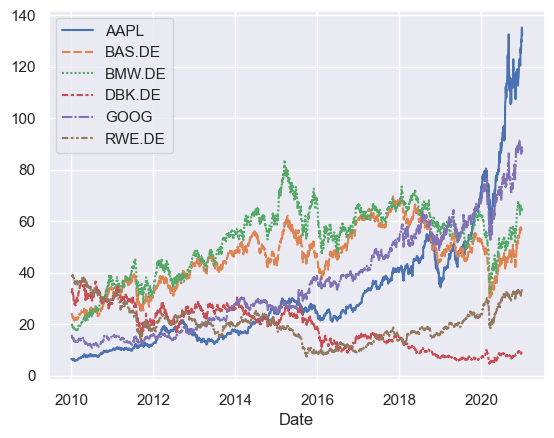

In [6]:
sns.lineplot(data = data);

In [48]:
data2 = pd.DataFrame(np.diff(np.log(data[1:]), axis=0) * 100, columns=data.columns)

In [49]:
data2.head()

,AAPL,BAS.DE,BMW.DE,DBK.DE,GOOG,RWE.DE
0,0.172742,-1.527800,0.807971,1.600661,-0.441336,-0.640084
1,-1.603402,0.631920,1.535660,-1.051189,-2.553194,-0.189908
2,-0.185056,-0.665862,0.879967,0.449103,-2.355478,-0.424948
3,0.662647,-0.306197,-1.353524,3.578286,1.324303,-0.146948
4,-0.886091,-1.119392,-1.496358,-1.210318,-0.151272,1.169604


In [57]:
data2 = data2.dropna(axis=0)

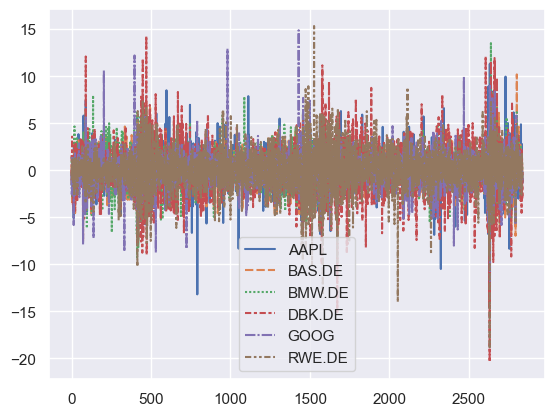

In [62]:
sns.lineplot(data = data2);

<AxesSubplot:ylabel='AAPL'>

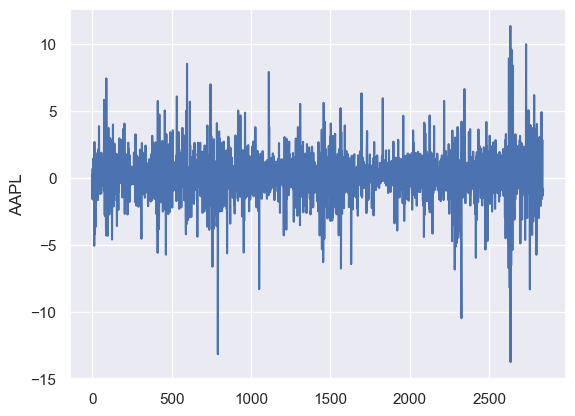

In [60]:
sns.lineplot(data = data2.AAPL)

In [94]:
mu = np.mean(data2)
Cov = np.cov(data2, rowvar=0)
C1 = np.linalg.inv(Cov)

c:\Users\morit\anaconda3\envs\myenv\lib\site-packages\numpy\core\fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [123]:
a = mu[np.newaxis, :] * C1 * mu[np.newaxis, :]
b = np.ones([1,6])[np.newaxis, :] * C1 *  mu[np.newaxis, :]
d = np.ones([1,6])[np.newaxis, :] * C1 *  np.ones([1,6])[np.newaxis, :]

C:\Users\morit\AppData\Local\Temp\ipykernel_13776\896987765.py:1: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  a = mu[np.newaxis, :] * C1 * mu[np.newaxis, :]
C:\Users\morit\AppData\Local\Temp\ipykernel_13776\896987765.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  b = np.ones([1,6])[np.newaxis, :] * C1 *  mu[np.newaxis, :]


In [316]:
w = np.random.random([1000,6])


In [317]:
for i in range(0, w.shape[0]):
    w[i] = w[i] / w[i].sum()

In [318]:
returns_aapl = w[0:]

In [319]:
w[0,0] * data2.iloc[0,0]

0.04155215429377314

In [320]:
data2.iloc[0,0]

0.1727420140340774

In [321]:
returns_test = np.empty_like(w)

In [322]:
for i in range(0, w.shape[0]):
    for j in range(0, data2.shape[1]):
        returns_test[i,j] = w[i,j] * data2.iloc[i,j]

In [323]:
returns_mean = returns_test.mean(axis=1)
returns_std = returns_test.std(axis = 1)

In [324]:
results = pd.DataFrame([returns_mean, returns_std]).T


In [325]:
results.columns = ["mean", "std"]

In [326]:
results.head()

,mean,std
0,0.064607,0.252073
1,-0.159321,0.307781
2,-0.057243,0.170303
3,0.034552,0.196215
4,-0.051740,0.193229


In [327]:
results.shape

(1000, 2)

<AxesSubplot:xlabel='std', ylabel='mean'>

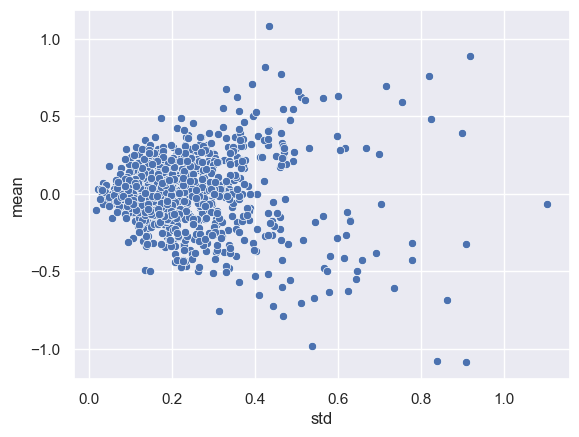

In [328]:
sns.scatterplot(y = results["mean"], x = results["std"])

In [ ]:
sns.scatterplot